# **Importing Libraries**

In [ ]:
!pip install hmmlearn

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import warnings 
import datetime
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn.neighbors import NearestNeighbors
#from sklearn.decomposition import PCA
#from hmmlearn import hmm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive

In [ ]:
data =pd.read_csv('/content/drive/MyDrive/US_weather_events/WeatherEvents_Jan2016-Dec2020.csv')

# **Data Preprocessing & Visualizaion**

Text(0, 0.5, '')

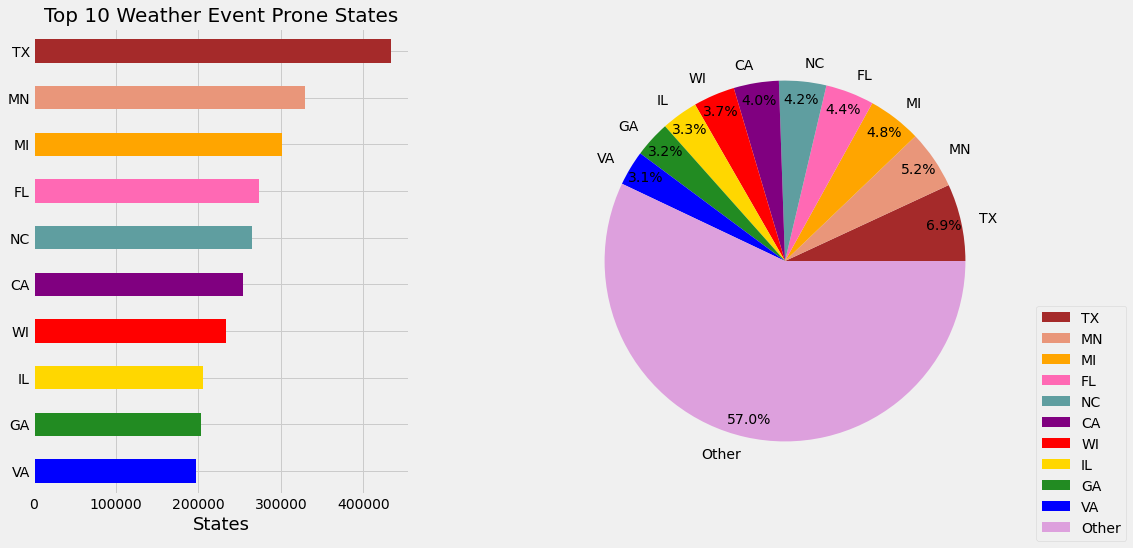

In [ ]:
weather_events=data
plt.style.use('fivethirtyeight')

fig,ax=plt.subplots(1,2,figsize=(15,8))
clr = ("blue", "forestgreen", "gold", "red", "purple",'cadetblue','hotpink','orange','darksalmon','brown')
weather_events.State.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',color=clr,ax=ax[0])
ax[0].set_title("Top 10 Weather Event Prone States",size=20)
ax[0].set_xlabel('States',size=18)


count=weather_events['State'].value_counts()
groups=list(weather_events['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')

In [ ]:
datetimeFormat = '%Y-%m-%d %H:%M:%S'
data['End']=pd.to_datetime(data['EndTime(UTC)'], format=datetimeFormat)
data['Start']=pd.to_datetime(data['StartTime(UTC)'], format=datetimeFormat)
data['Duration']=data['End']-data['Start']
data['Duration'] = data['Duration'].dt.total_seconds()
data['Duration'] = data['Duration']/(60*60)  #in hours
data = data[(data['Duration']< 30*24) & (data['Duration'] != 0)] #removes obvious wrong data
data.head(3)

In [ ]:
df=data

In [ ]:
print("Overall Duration Summary")
print("Count: ", df['Duration'].size)
#print("--%miss.", sum(df['Duration'].isnull()))
#print("--card.",df['Duration'].unique().size)
print("Min:",df['Duration'].min())
print("LowerBoundary:",df['Duration'].median()-1.5*((df['Duration'].quantile(0.75))-df['Duration'].quantile(0.25)))
print("1st Quantile:",df['Duration'].quantile(0.25))
print("Mean:",df['Duration'].mean())
print("Median:",df['Duration'].median())
print("3rd Quanile:",df['Duration'].quantile(0.75))
print("UpperBoundary:",df['Duration'].median()+1.5*((df['Duration'].quantile(0.75))-df['Duration'].quantile(0.25)))
print("95% Boundary:",df['Duration'].mean()+1.96*df['Duration'].std())
print("Max:",df['Duration'].max())
print("Std.Dev:",df['Duration'].std())

Overall Duration Summary
Count:  6273901
Min: 0.01666666666666667
LowerBoundary: -0.7583333333333336
1st Quantile: 0.3333333333333333
Mean: 1.3134282960336185
Median: 0.6666666666666666
3rd Quanile: 1.2833333333333334
UpperBoundary: 2.091666666666667
95% Boundary: 10.008941214766804
Max: 718.6666666666666
Std.Dev: 4.436486183027135


In [ ]:
df2 = df.groupby(['AirportCode','City','State', 'LocationLat', 'LocationLng','Type']).agg({'Duration':['sum']}).reset_index()
df2.columns=pd.MultiIndex.from_tuples(( ("AirportCode", " "),("City", " "),("State", " "), ("LocationLat", " "),("LocationLng", " "), ("Type", " "), ("Duration", " ") ))
df2.columns = df2.columns.get_level_values(0)
df2['Duration'] = df2['Duration']/(24*4*3.65) #yearly percentage  
df2 = df2.sort_values(by='Duration')
#df2.shape
df2

,AirportCode,City,State,LocationLat,LocationLng,Type,Duration
8570,KOWB,Owensboro,KY,37.7388,-87.1668,Hail,0.000048
6729,KLSF,Fort Benning,GA,32.3239,-84.9826,Hail,0.000048
10139,KSHR,Sheridan,WY,44.7603,-106.9741,Hail,0.000048
8919,KPLU,Puyallup,WA,47.1039,-122.2872,Hail,0.000048
8849,KPIA,Peoria,IL,40.6675,-89.6839,Storm,0.000095
...,...,...,...,...,...,...,...
9915,KSBD,San Bernardino,CA,34.0903,-117.2471,Fog,22.445443
8056,KNRS,Imperial Beach,CA,32.5630,-117.1109,Cold,24.517123
10598,KSXT,Wolf Creek,OR,42.6000,-123.3656,Fog,25.214326
7785,KMWN,Sargents,NH,44.2708,-71.3035,Fog,25.338994


In [ ]:
df_flat = df2.pivot( index='AirportCode',columns='Type', values=['Duration']).reset_index().fillna(0)
df_flat.columns=pd.MultiIndex.from_tuples(((' ', 'AirportCode'),(' ', 'Cold'),(' ', 'Fog'),(' ',  'Hail'),(' ', 'Precipitation'),(' ', 'Rain'),(' ', 'Snow'),(' ', 'Storm')))
df_flat.columns = df_flat.columns.get_level_values(1)

uniqueKey = df2[['AirportCode', 'City','State', 'LocationLat', 'LocationLng']].sort_values(by='AirportCode').drop_duplicates()
weather = pd.merge(df_flat, uniqueKey, how='inner', on='AirportCode')
weather

In [ ]:
fig_rain = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Fog",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      range_color = [0,16],
                      scope="usa",
                      title ='fig 4. City wide rainy days percentage each year from 2016 to 2019')
#fig_rain.update_layout(height=750, width=1000)
fig_rain.show()

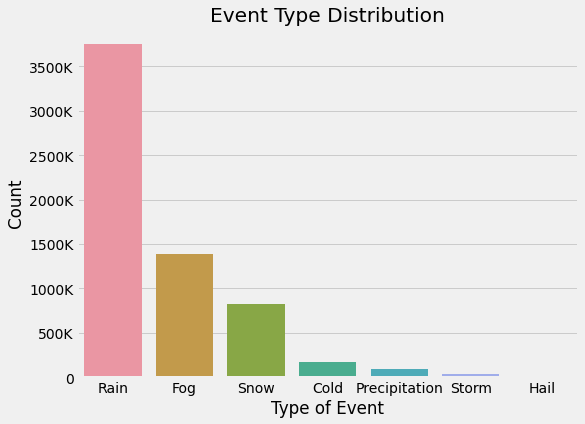

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,6))
sns.countplot('Type',data=data,order=data['Type'].value_counts().index)
ax.set_title('Event Type Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Type of Event')
ax.set_yticks([0,500000,1000000,1500000,2000000,2500000,3000000,3500000])
ax.set_yticklabels(labels=['0','500K','1000K','1500K','2000K','2500K','3000K','3500K'])
plt.show()

# **K-Means**

city wide analysis: 

In [ ]:
X = df_flat.drop(['AirportCode','Cold', 'Hail'], axis=1)

In [ ]:
X

,Fog,Precipitation,Rain,Snow,Storm
0,2.934836,0.527873,9.464041,0.199153,0.000000
1,0.113680,0.011653,2.151494,2.187643,0.082572
2,2.217275,0.039051,5.167000,4.605594,0.000999
3,3.017504,0.026636,2.018645,5.937976,0.201674
4,8.677702,0.000000,1.904490,4.062024,0.079909
...,...,...,...,...,...
2062,4.783818,0.006659,3.822298,1.624667,0.002854
2063,1.202102,0.056935,4.287148,3.642171,0.112015
2064,3.134751,0.108780,13.084951,9.998240,0.001237
2065,2.233638,0.063737,5.959855,0.000000,0.001903


In [ ]:
from sklearn.cluster import KMeans
distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(X)
    distortions.append(kmean.inertia_)

In [ ]:
fig_kmean = px.scatter(x=K, y=distortions,title='Fig 8. The Elbow Method')
fig_kmean.update_xaxes(title_text='k')
fig_kmean.update_yaxes(title_text='distortion')
#fig_kmean.update_layout(height=650, width=1000)
fig_kmean.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

df_flat['Cluster'] = (kmeans.labels_).astype(str)
df_cluster = pd.merge(df_flat[['AirportCode','Cluster']], weather.drop(['Cold','Hail'], axis=1), 
                      how='inner', on='AirportCode')
df_cluster.tail(3)

,AirportCode,Cluster,Fog,Precipitation,Rain,Snow,Storm,City,State,LocationLat,LocationLng
2064,KYNG,2,3.134751,0.108780,13.084951,9.998240,0.001237,Vienna,OH,41.2544,-80.6739
2065,KZPH,1,2.233638,0.063737,5.959855,0.000000,0.001903,Zephyrhills,FL,28.2281,-82.1559
2066,KZZV,1,2.615059,0.096984,8.308980,2.519264,0.000000,Zanesville,OH,39.9444,-81.8921


In [ ]:
fig_cluster = px.scatter_geo(df_cluster, lat='LocationLat', lon='LocationLng',
                      hover_name=weather['City'] + ', ' + weather['State'],
                      scope="usa",
                      color_discrete_sequence =['#AB63FA', '#EF553B', '#00CC96','#636EFA'],
                      color = 'Cluster',
                      title ='fig 9. City wide weather cluster distribution')
#fig_cluster.update_layout(height=750, width=1000)
fig_cluster.show()

state wide analysis: 

In [ ]:
df_cluster2 = df_cluster.groupby(['State','Cluster']).agg({'Cluster':['count']}).reset_index()
df_cluster2.columns=pd.MultiIndex.from_tuples((("State", " "),("Cluster", " "),("Count", " ")))
df_cluster2.columns = df_cluster2.columns.get_level_values(0)
#df_cluster2.tail(3) #state with each cluster counts

df_loc = df_cluster[['State','Cluster','LocationLat', 'LocationLng']]
df_loc1 = df_loc.groupby(['State','Cluster']).agg({'LocationLat':'mean'}).reset_index()
df_loc2 = df_loc.groupby(['State','Cluster']).agg({'LocationLng':'mean'}).reset_index()
df_loc3 = pd.merge(df_loc1,df_loc2, how='inner', on=['State','Cluster'])
#df_loc3.tail(3) #state with cluster and location

df_clusterS = pd.merge(df_loc3,df_cluster2, how='inner', on=['State','Cluster'])
df_clusterS.tail(3) #state with each cluster count location

,State,Cluster,LocationLat,LocationLng,Count
107,WV,2,39.001000,-80.271200,1
108,WY,0,42.763600,-107.268105,21
109,WY,2,42.662003,-107.501161,33


In [ ]:
fig_clusterS = px.scatter_geo(df_clusterS, lat='LocationLat', lon='LocationLng', 
                     color='Cluster',
                     size='Count',
                     color_discrete_sequence=['#636EFA', '#AB63FA', '#EF553B','#00CC96'],
                     hover_name='State',
                     scope="usa",
                     title = 'Fig 10. State wide weather cluster distribution')
#fig_clusterS.update_layout(height=750, width=1000)
fig_clusterS.show()